# Farfetch case study

## Product category classification

* Author: Kai Chen
* Date: Apr, 2018

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import itertools
import operator
from random import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_recall_curve, precision_score, recall_score, average_precision_score 

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras import callbacks, applications, optimizers

np.random.seed(42)

In [4]:
# ---------------------
# Define the file paths

PRODUCT_CSV_FILE = 'data/products.csv'
ATTRIBUTE_CSV_FILE = 'data/attributes.csv'

## Step 1: read and explore the data

In [5]:
df_product = pd.read_csv(PRODUCT_CSV_FILE)

display(df_product.head(5))
print(df_product.shape)

list_product_id = df_product['ProductId'].unique()
list_product_id = np.array(list_product_id)
print('number of products {}'.format(list_product_id.shape[0]))

,ProductId,Description,DescriptionDate,SeasonOriginal,ProductName,Brand,Gender,Colour,Family,Category,ArticlePhotoId,CreateDate
0,11295277,VIPE6CE-169953MCC 38NO,2016-01-07 13:13:09.527,SS15,Celine Black Phantom Bag,CELINE COLLARD,WOMEN,BLACK,Bags,Tote Bags,6129459,2016-01-07 13:10:46.507
1,11292059,Grey cotton 'Skip' crewneck from S.N.S. Herni...,2016-01-08 14:45:59.673,SS16,'Skip' crewneck,S.N.S. HERNING,MEN,GREY,Clothing,Sweaters & Knitwear,6156126,2016-01-04 19:52:05.203
2,11290981,Multicolour cotton 'Pak’r Tatenda' backpack fr...,2016-01-11 19:27:45.330,SS16,'Pakr Tatenda' backpack,EASTPAK,UNISEX,YELLOW & ORANGE,Bags,Backpacks,6216609,2016-01-03 15:21:20.480
3,11293179,Ivory white and black hemp-cotton blend 'Honey...,2016-01-13 11:33:11.150,SS16,'Honey' wide brim hat,EUGENIA KIM,WOMEN,WHITE,Accessories,Hats,6199465,2016-01-05 18:08:57.317
4,11293099,Ivory white cotton embroidered lace frilled dr...,2016-01-13 15:22:08.247,SS16,embroidered lace frilled dress,RED VALENTINO,WOMEN,WHITE,Clothing,Dresses,6173011,2016-01-05 16:55:35.427


(12631, 12)
number of products 12631


In [6]:
list_category = df_product['Category'].unique()
list_category = np.array(list_category)

display(df_product['Category'][0:5])
display('number of category {}'.format(list_category.shape[0]))

0              Tote Bags
1    Sweaters & Knitwear
2              Backpacks
3                   Hats
4                Dresses
Name: Category, dtype: object

'number of category 134'

In [7]:
# Create a dictionary with key: product id -> value: category
# Note in this csv file we can find that each product belongs to only one category

dict_product_cat = dict()
for product_id in list_product_id:
    category = df_product[df_product['ProductId'] == product_id]['Category'].values
    if (len(category)) > 1:
         print('product {} belongs to more than two categories.'.format(product_id))
    dict_product_cat[product_id] = category[0]
    
for product_id in list_product_id[0:5]:
    print(dict_product_cat[product_id])

Tote Bags
Sweaters & Knitwear
Backpacks
Hats
Dresses


In [8]:
# Create a dictionary with key: category -> value: a list of product id
dict_cat = dict()
dict_cat_nb_products = dict()
nb_products_cat = []
for category in list_category:
    products = df_product[df_product['Category'] == category]['ProductId'].values
    dict_cat[category] = products
    dict_cat_nb_products[category] = len(products)
    nb_products_cat.append(len(products))
    
for category in list_category[0:5]:
    print('category {}, number of products {}'.format(category, dict_cat_nb_products[category]))


category Tote Bags, number of products 341
category Sweaters & Knitwear, number of products 529
category Backpacks, number of products 101
category Hats, number of products 149
category Dresses, number of products 1022


plot number of products per category


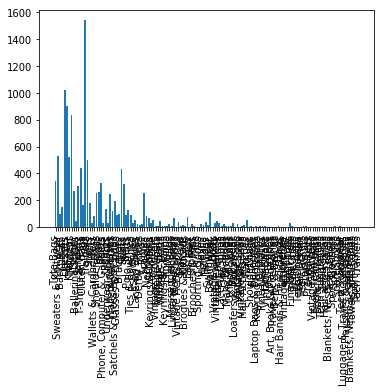

In [9]:
# Show number of products per category
print('plot number of products per category')
plt.bar(range(len(dict_cat_nb_products)), list(dict_cat_nb_products.values()), align='center')
plt.xticks(range(len(dict_cat_nb_products)), list(dict_cat_nb_products.keys()))
plt.xticks(rotation=90)
# # for python 2.x:
# plt.bar(range(len(dict_cat_nb_products)), dict_cat_nb_products.values(), align='center')  # python 2.x
# plt.xticks(range(len(dict_cat_nb_products)), dict_cat_nb_products.keys())  # in python 2.x
plt.show()
    

In [10]:
# Get max and min number of products per category
min_products = sys.maxsize
min_products_cat = ''
max_products = 0
max_products_cat = ''
for category, nb_products in dict_cat_nb_products.items():
    if nb_products < min_products:
        min_products = nb_products
        min_products_cat = category
    if nb_products > max_products:
        max_products = nb_products
        max_products_cat = category

print('category {} has the max number of products, i.e., {}'.format(max_products_cat, max_products))
print('category {} has the min number of products, i.e., {}'.format(min_products_cat, min_products))
print('mean number of products per category: {}'.format(round(np.mean(nb_products_cat), 2)))
print('standard deviation of number of products per category: {}'.format(round(np.std(nb_products_cat), 2)))


category Tops has the max number of products, i.e., 1539
category Ties has the min number of products, i.e., 1
mean number of products per category: 94.26
standard deviation of number of products per category: 211.19


In [11]:
# Create a dictionary with key: photo id -> value: product id
# Note one photo belongs only to one product
list_photo_id = df_product['ArticlePhotoId'].unique()
dict_photo_product_id = dict()
for photo_id in list_photo_id:
    dict_photo_product_id[photo_id] = df_product[df_product['ArticlePhotoId']==photo_id]['ProductId'].values[0]


## Step 2: prepare train, test sets

In [12]:
percentage_train_set = 0.7

shuffle(list_product_id)

list_product_id_train = list_product_id[0:int(percentage_train_set*len(list_product_id))]
list_product_id_test = list_product_id[len(list_product_id_train):]

print('number of samples {}'.format(len(list_product_id)))
print('number of trainig samples {}'.format(len(list_product_id_train)))
print('number of trainig samples {}'.format(len(list_product_id_test)))


number of samples 12631
number of trainig samples 8841
number of trainig samples 3790


## Step 3: train a CNN model for category classification

#### References
- https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
- https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://github.com/tatsuyah/CNN-Image-Classifier/blob/master/src/train-multiclass.py
- https://www.kaggle.com/fujisan/use-keras-pre-trained-vgg16-acc-98


In [13]:
class_names = list_category

# Note due to computation cost images are resized to smaller sizes
# img_width, img_height = 80, 80
img_width, img_height = 100, 100

train_img_x = []
train_img_y = []
test_img_x = []
test_img_y = []

In [14]:
# ------------
# Get training and test images

img_dir_path = "data/images_{}_{}/".format(img_width, img_height)
dirs = os.listdir(img_dir_path)

# key: product id, value: image path
dict_img_path = dict()

for file_name in dirs:
    file_path = os.path.join(img_dir_path, file_name)

    img = load_img(file_path)         # this is a PIL image
    x = img_to_array(img)             # this is a Numpy array with shape (img_width, img_height, 3)
    # x = x.reshape((1,) + x.shape)   # this is a Numpy array with shape (1, 3, img_width, img_height)

    product_id = int(file_name.split('_')[0])

    dict_img_path[product_id] = file_path

    if not product_id in list_product_id:
        print('photo {} does not have product information'.format(file_path))

    if product_id in list_product_id:
        if product_id in list_product_id_train:
            train_img_x.append(x)
            train_img_y.append(dict_product_cat[product_id])
        elif product_id in list_product_id_test:
            test_img_x.append(x)
            test_img_y.append(dict_product_cat[product_id])

train_img_x = np.array(train_img_x)
train_img_y = np.array(train_img_y)
test_img_x = np.array(test_img_x)
test_img_y = np.array(test_img_y)

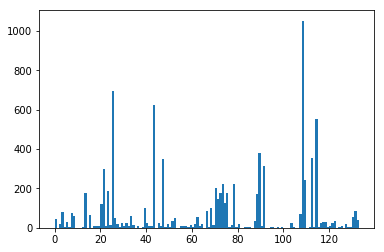

In [15]:
# ----------
# Transform category to one-hot encoding

le = preprocessing.LabelEncoder()
le.fit(class_names)
train_img_y = le.transform(train_img_y)
test_img_y = le.transform(test_img_y)

plt.hist(train_img_y.tolist(), range(min(train_img_y), max(train_img_y)+1))
plt.show()

In [16]:
train_img_y = to_categorical(train_img_y, num_classes = len(class_names))
test_img_y = to_categorical(test_img_y, num_classes = len(class_names))

# Split the train and the validation set for the fitting
train_img_x, val_img_x, train_img_y, val_img_y = train_test_split(train_img_x, train_img_y, test_size = 0.1, random_state=42)

print('train set shape')
print(np.array(train_img_x).shape)
print('validation set shape')
print(np.array(val_img_x).shape)

train set shape
(7830, 100, 100, 3)
validation set shape
(870, 100, 100, 3)


In [21]:
# ----------------------
# CNN hyperparameters

epochs = 20
batch_size = 32
filters = [16, 16, 8, 8]
kernel_sizes = [11, 11, 7, 7]
strides = [2, 2, 2, 2]
pooling_sizes = [2, 2]

str_parameters = '[epochs]{}-[batch_size]{}-[filters]{}-[kernel_sizes]{}-[strides]{}-[pooling_sizes]{}'.format(epochs,
                                                                                                                batch_size,
                                                                                                                '_'.join(str(x) for x in filters),
                                                                                                                '_'.join(str(x) for x in kernel_sizes),
                                                                                                                '_'.join(str(x) for x in strides),
                                                                                                                '_'.join(str(x) for x in pooling_sizes),
                                                                                                                )

#model_name = 'CNN'     # about 40% accuracy
model_name = 'VGG16'  # require GPU 


In [22]:
# ----------------
# Define the CNN models

model = None
if model_name == 'CNN':
    model = Sequential()

    model.add(Conv2D(filters = filters[0], kernel_size = (kernel_sizes[0], kernel_sizes[0]),
                     padding = 'Same', strides=strides[0],  input_shape = (img_width, img_height, 3)),
                     #activation ='relu',
                    )
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = filters[1], kernel_size = (kernel_sizes[1], kernel_sizes[1]),
                     padding = 'Same', strides=strides[1],
                     #activation ='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPool2D(pool_size=(pooling_sizes[0], pooling_sizes[0])))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = filters[2], kernel_size = (kernel_sizes[2], kernel_sizes[2]),
                     padding = 'Same', strides=strides[2],
                     #activation ='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = filters[3], kernel_size = (kernel_sizes[3], kernel_sizes[3]),
                     padding = 'Same', strides=strides[3],
                     #activation ='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPool2D(pool_size=(pooling_sizes[1], pooling_sizes[1])))
    model.add(Dropout(0.2))

    model.add(Flatten())
    #model.add(Dense(256, activation = "relu"))
    model.add(Dense(256, kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(len(class_names), activation = "softmax"))

elif model_name == 'VGG16':
    # use pre-trained VGG16
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))

    add_model.add(Dense(256, kernel_initializer='glorot_uniform'))
    # add_model.add(Dense(1, activation='sigmoid'))
    add_model.add(BatchNormalization())
    add_model.add(Activation('relu'))
    add_model.add(Dropout(0.2))

    add_model.add(Dense(len(class_names), activation="softmax"))

    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    # model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    #              metrics=['accuracy'])

print(model.summary())

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#optimizer = optimizers.SGD(lr=1e-3, momentum=0.9) 

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [23]:
# -----------
# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,               # set input mean to 0 over the dataset
        samplewise_center=False,                # set each sample mean to 0
        featurewise_std_normalization=False,    # divide inputs by std of the dataset
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening
        rotation_range=10,                      # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                       # randomly zoom image
        width_shift_range=0.1,                  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                 # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                  # randomly flip images
        vertical_flip=False)                    # randomly flip images

datagen.fit(train_img_x)

Epoch 1/20
 - 28s - loss: 3.0107 - acc: 0.2628 - val_loss: 3.8900 - val_acc: 0.3540
Epoch 2/20
 - 28s - loss: 2.2656 - acc: 0.4103 - val_loss: 2.8168 - val_acc: 0.4356
Epoch 3/20
 - 29s - loss: 2.0246 - acc: 0.4674 - val_loss: 2.6853 - val_acc: 0.4506
Epoch 4/20
 - 28s - loss: 1.9145 - acc: 0.5004 - val_loss: 1.9806 - val_acc: 0.5103
Epoch 5/20
 - 29s - loss: 1.8154 - acc: 0.5182 - val_loss: 2.0464 - val_acc: 0.5149
Epoch 6/20
 - 29s - loss: 1.7456 - acc: 0.5342 - val_loss: 1.8937 - val_acc: 0.5609
Epoch 7/20
 - 28s - loss: 1.6818 - acc: 0.5573 - val_loss: 1.9522 - val_acc: 0.5218
Epoch 8/20
 - 28s - loss: 1.6443 - acc: 0.5606 - val_loss: 1.7164 - val_acc: 0.5713
Epoch 9/20
 - 29s - loss: 1.5890 - acc: 0.5767 - val_loss: 2.0581 - val_acc: 0.5103
Epoch 10/20
 - 28s - loss: 1.5640 - acc: 0.5878 - val_loss: 1.7970 - val_acc: 0.6184
Epoch 11/20
 - 28s - loss: 1.5227 - acc: 0.5901 - val_loss: 2.5165 - val_acc: 0.5943
Epoch 12/20
 - 27s - loss: 1.5103 - acc: 0.5957 - val_loss: 1.6176 - val_a

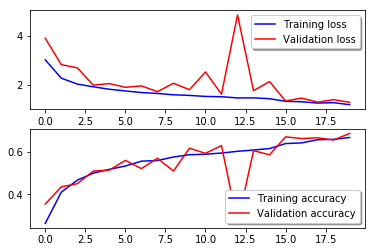

In [24]:
# -------------
# Train the CNN model
history = model.fit_generator(datagen.flow(train_img_x, train_img_y, batch_size=batch_size),
                              epochs = epochs, validation_data = (val_img_x, val_img_y),
                              verbose = 2, steps_per_epoch=train_img_x.shape[0] // batch_size, callbacks=[learning_rate_reduction])


# Training and validation curves
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


plt.show()

In [25]:
# Save the model
model_dir = './models/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = ''
if model_name == 'CNN':
    model_path = '{}cat-cnn-model-{}.h5'.format(model_dir, str_parameters)
elif model_name == 'VGG16':
    model_path = '{}cat-vgg16-{}-{}.h5'.format(model_dir, epochs, batch_size)
model.save(model_path)
print('save model to {}'.format(model_path))

model_weights_path = ''
if model_name == 'CNN':
    model_weights_path = '{}cat-cnn-weights-{}.h5'.format(model_dir, str_parameters)
elif model_name == 'VGG16':
    model_weights_path = '{}cat-vgg16-weights-{}-{}.h5'.format(model_dir, epochs, batch_size)
model.save_weights(model_weights_path)
print('save weights to {}'.format(model_weights_path))


save model to ./models/cat-vgg16-20-32.h5
save weights to ./models/cat-vgg16-weights-20-32.h5


## Step 4: make predictions

In [26]:
model = load_model(model_path)
model.load_weights(model_weights_path)

test_pred = model.predict(test_img_x)

## Step 5: evaluation

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# convert predictions classes to one hot vectors
test_pred_classes = np.argmax(test_pred, axis = 1)
# results = pd.Series(test_pred_classes, name="Label")

# convert test observations to one hot vectors
test_true_classes = np.argmax(test_img_y, axis = 1)

acc_score =accuracy_score(test_true_classes, test_pred_classes)
print('accuracy {}'.format(acc_score))

# compute the confusion matrix
test_true_classes = le.inverse_transform(test_true_classes)
test_pred_classes = le.inverse_transform(test_pred_classes)

print(classification_report(test_true_classes, test_pred_classes, target_names=class_names))

confusion_mtx = confusion_matrix(test_true_classes, test_pred_classes)
#display(confusion_mtx[0:5][0:5])

#plot the confusion matrix
#confusion_mtx = confusion_mtx
#plot_confusion_matrix(confusion_mtx, classes = range(len(class_names)))
#plt.show()

precision = precision_score(test_true_classes, test_pred_classes, average=None)
recall = recall_score(test_true_classes, test_pred_classes, average=None)
f1 = f1_score(test_true_classes, test_pred_classes, average=None)

print('precision')
print(precision)

print('recall')
print(recall)

print('f1')
print(f1)


accuracy 0.6809421841541756
                              precision    recall  f1-score   support

                   Tote Bags       0.75      0.55      0.63        11
         Sweaters & Knitwear       0.00      0.00      0.00         1
                   Backpacks       1.00      0.18      0.31        11
                        Hats       0.67      0.74      0.70        19
                     Dresses       0.00      0.00      0.00         3
                     Jackets       0.63      0.71      0.67        17
                    Knitwear       0.00      0.00      0.00         1
                    Trousers       0.65      0.49      0.56        35
                       Denim       0.75      1.00      0.86        30
             Ballerina Shoes       0.00      0.00      0.00         1
                     Sandals       0.86      0.92      0.89        84
            T-Shirts & Vests       0.00      0.00      0.00         1
                 Clutch Bags       0.70      0.79      0.74  

/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 110, does not match size of target_names, 134
  .format(len(labels), len(target_names))
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pr

error classified products
[11585285, 11550083, 11333264, 11874577, 11805119]
correct classified products
[11878270, 11747842, 11867486, 11335559, 11887303]
2544 / 3736 products are classified correctly
same errors


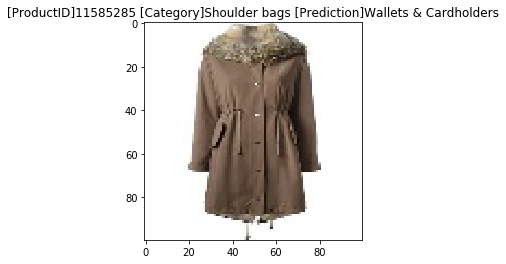

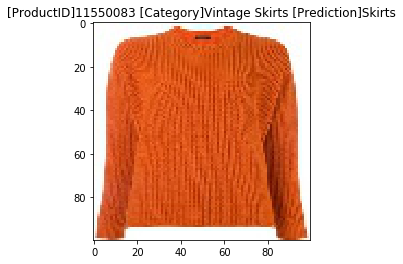

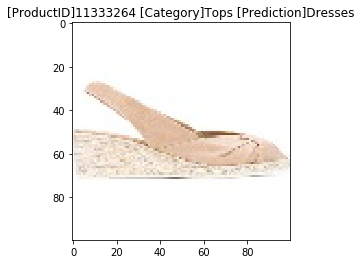

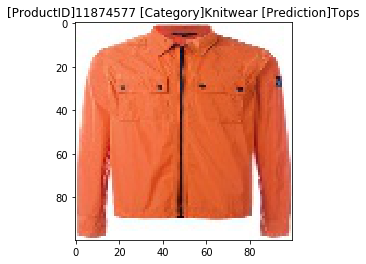

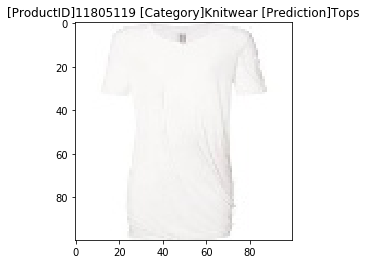

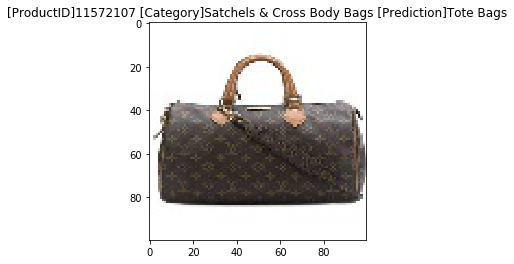

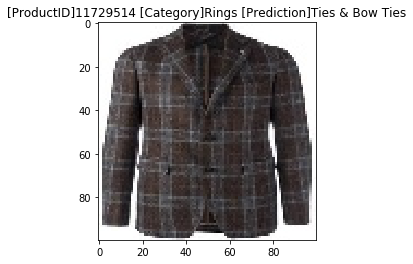

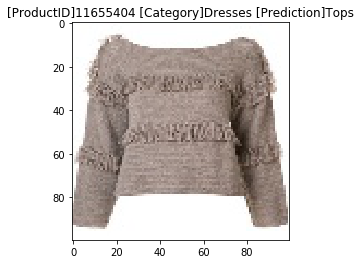

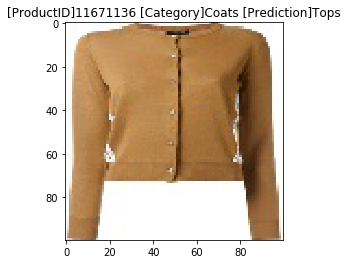

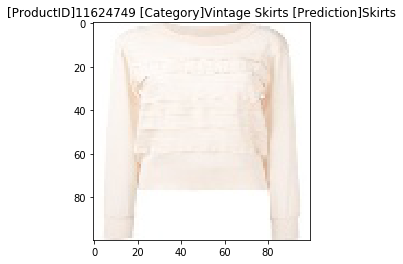

some correctly classifier products


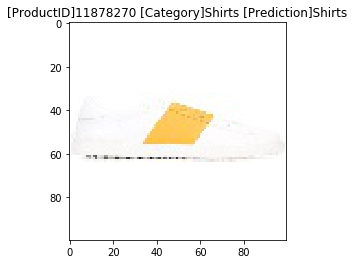

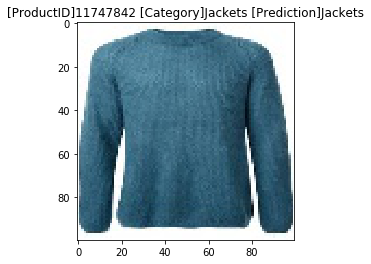

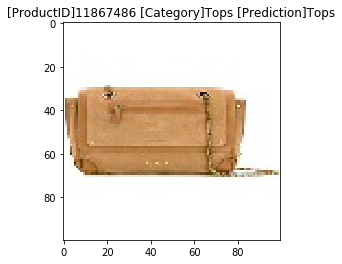

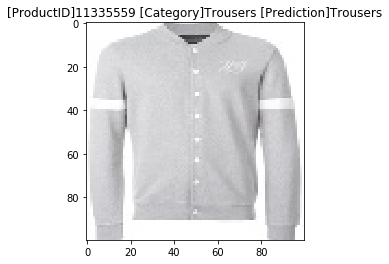

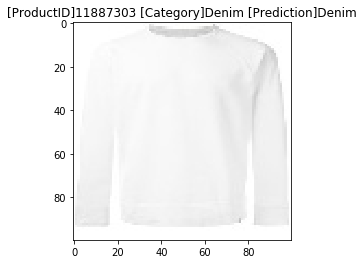

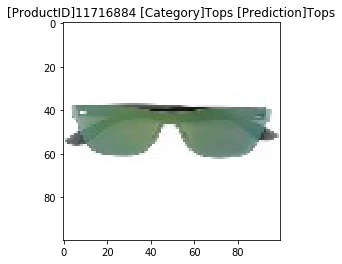

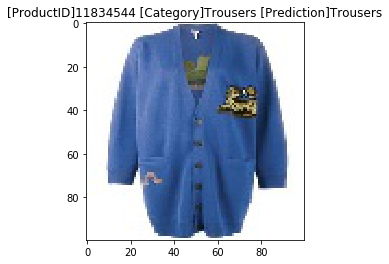

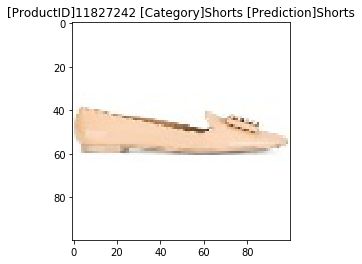

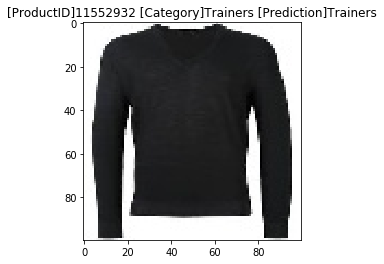

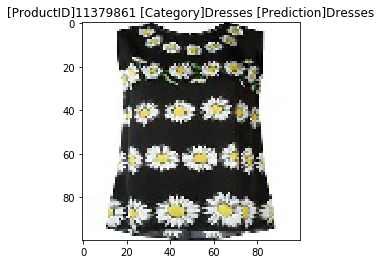

In [28]:
# ----------
# Display some error results

test_true_classes = np.array(test_true_classes).reshape((test_img_x.shape[0], 1))
test_pred_classes = np.array(test_pred_classes).reshape((test_img_x.shape[0], 1))

error_indices = []
correct_indices = []
for i, val in enumerate(test_true_classes):
    if test_true_classes[i][0] != test_pred_classes[i][0]:
        error_indices.append(i)
    else:
        correct_indices.append(i)

list_error_product_id = []
list_error_product_true_class = []
list_error_product_pred_class = []
for i in error_indices:
    list_error_product_id.append(list_product_id_test[i])
    list_error_product_true_class.append(test_true_classes[i][0])
    list_error_product_pred_class.append(test_pred_classes[i][0])
    
print('error classified products')
print(list_error_product_id[0:5])

list_correct_product_id = []
list_correct_product_true_class = []
list_correct_product_pred_class = []
for i in correct_indices:
    list_correct_product_id.append(list_product_id_test[i])
    list_correct_product_true_class.append(test_true_classes[i][0])
    list_correct_product_pred_class.append(test_pred_classes[i][0])
    
print('correct classified products')
print(list_correct_product_id[0:5])

print('{} / {} products are classified correctly'.format(len(correct_indices), test_true_classes.shape[0]))
#acc = 1 - len(list_error_product_id) / len(list_product_id_test)
#print('accuracy {}'.format(acc))

print('same errors')
for index in range(0, 10):
    img = mpimg.imread(dict_img_path[list_error_product_id[index]])
    imgplot = plt.imshow(img)
    plt.title('[ProductID]{} [Category]{} [Prediction]{}'.format(list_error_product_id[index], 
                                                                 list_error_product_true_class[index], 
                                                                 list_error_product_pred_class[index]))
    plt.show()
    
    
print('some correctly classifier products')
for index in range(0, 10):
    img = mpimg.imread(dict_img_path[list_correct_product_id[index]])
    imgplot = plt.imshow(img)
    plt.title('[ProductID]{} [Category]{} [Prediction]{}'.format(list_correct_product_id[index], 
                                                                 list_correct_product_true_class[index], 
                                                                 list_correct_product_pred_class[index]))
    plt.show()




## Future work

- Improve the report the performance
- Transfer learning
- Data augmentation
- Combine vision and text information